In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import shapiro
# import nplinalg least squares
import scipy.stats as stats
import statsmodels.api as sm
import scipy
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import pickle 
from typing import Callable, Any, Iterable

In [146]:
import warnings
warnings.filterwarnings('ignore')

In [147]:
print(pd. __version__)

2.2.1


In [148]:
print(sns.__version__)

0.13.2


In [149]:
pd.options.mode.chained_assignment = None

In [150]:
pd.options.mode.copy_on_write = False

### STOCKS

In [151]:
df_tickers = pd.read_csv('data/SPY holdings.csv')

In [152]:
df_tickers

,Ticker,sector,sectorKey,industry,beta,marketCap
0,MSFT,Technology,technology,Software - Infrastructure,0.890,3.094184e+12
1,AAPL,Technology,technology,Consumer Electronics,1.289,2.665581e+12
2,NVDA,Technology,technology,Semiconductors,1.725,2.195913e+12
3,AMZN,Consumer Cyclical,consumer-cyclical,Internet Retail,1.171,1.811770e+12
4,META,Communication Services,communication-services,Internet Content & Information,1.208,1.234169e+12
...,...,...,...,...,...,...
499,ZION,Financial Services,financial-services,Banks - Regional,1.117,5.872965e+09
500,MHK,Consumer Cyclical,consumer-cyclical,"Furnishings, Fixtures & Appliances",1.331,7.505347e+09
501,VFC,Consumer Cyclical,consumer-cyclical,Apparel Manufacturing,1.527,5.746700e+09
502,FOX,Communication Services,communication-services,Entertainment,0.794,1.340617e+10


In [153]:
len(df_tickers)

504

In [154]:
tickers = list(df_tickers['Ticker'])

In [155]:
for i in range(len(tickers)):
    if '.' in tickers[i]:
        print(tickers[i])
        tickers[i] = tickers[i].replace('.', '-')
        print(tickers[i])

BRK.B
BRK-B
BF.B
BF-B


In [156]:
len(tickers)

504

In [157]:
%%time
# tickers.remove('QRVO')
data_yf = yf.download("SPY", period='16y', interval='1wk')[['Adj Close']]
data_yf.rename(columns={'Adj Close': "SPY"}, inplace=True)

tickers_with_errors = []
for ticker in tickers:
    data_ticker = yf.download(ticker, period='16y', interval='1wk')
    if not data_ticker.empty:
        data_ticker = data_ticker[["Adj Close"]]
        data_ticker.rename(columns={'Adj Close': ticker}, inplace=True)
        data_yf = data_yf.join(data_ticker, how='left')
    else:
        tickers_with_errors.append(ticker)
        print('Error, no data for the ticker: ', ticker)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Error, no data for the ticker:  -


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

CPU times: user 6.21 s, sys: 970 ms, total: 7.18 s
Wall time: 1min 38s


In [443]:
data = data_yf.copy(deep=True)

In [444]:
data.shape

(835, 504)

In [445]:
print(tickers_with_errors) # tickers with errors

['-']


In [447]:
data.columns[data.isna().sum() > len(data) - 200].tolist() # columns to drop

['ABBV', 'ABNB', 'CEG', 'KVUE', 'GEHC', 'VLTO', 'QRVO']

In [448]:
data = data.drop(columns=data.columns[data.isna().sum() > len(data) - 200].tolist()) # dropping columns

In [449]:
data.head()

,SPY,MSFT,AAPL,NVDA,AMZN,META,GOOGL,GOOG,BRK-B,LLY,...,FMC,HAS,PARA,WHR,DVA,ZION,MHK,VFC,FOX,NWS
Date,,,,,,,,,,,,,,,,,,,,,
2008-04-21,102.621132,21.750544,5.131906,4.620909,4.0430,NaN,13.615115,13.550709,84.599998,29.975395,...,22.301069,21.413500,15.623646,47.200863,24.950001,35.693096,76.949997,11.460096,NaN,NaN
2008-04-28,104.025185,21.320343,5.470847,5.164412,3.8655,NaN,14.546797,14.477983,88.959999,29.987549,...,21.690887,21.854136,17.084192,46.706619,26.115000,37.239021,78.349998,11.605541,NaN,NaN
2008-05-05,102.106514,21.429720,5.546738,5.166703,3.6205,NaN,14.344344,14.276488,83.580002,29.301319,...,23.437733,21.898727,17.133343,44.748154,25.934999,34.003159,75.550003,11.020766,NaN,NaN
2008-05-12,104.870544,21.867203,5.672820,5.597837,3.8230,NaN,14.516266,14.447597,81.540001,29.726410,...,24.288494,22.317236,16.445204,46.255611,25.915001,33.676426,77.610001,11.577046,NaN,NaN
2008-05-19,101.180298,20.527952,5.477800,5.299714,3.9175,NaN,13.629129,13.564656,82.599998,29.169523,...,24.079296,21.117054,15.939630,44.340393,25.695000,32.728436,73.059998,11.062746,NaN,NaN


In [450]:
data.isna().sum()[data.isna().sum() > 0]

META    212
AVGO     67
TSLA    114
NOW     218
UBER    576
       ... 
GNRC     94
NCLH    247
FOXA    568
FOX     568
NWS     269
Length: 63, dtype: int64

In [451]:
data.isna().sum().sum()

18295

In [452]:
tickers = list(data.columns)
# tickers.remove('SPY')

In [453]:
len(tickers)

497

In [454]:
data[['Return ' + ticker for ticker in tickers]] = np.log(data[tickers]).diff()
data = data.drop(columns = tickers)
data.head()

,Return SPY,Return MSFT,Return AAPL,Return NVDA,Return AMZN,Return META,Return GOOGL,Return GOOG,Return BRK-B,Return LLY,...,Return FMC,Return HAS,Return PARA,Return WHR,Return DVA,Return ZION,Return MHK,Return VFC,Return FOX,Return NWS
Date,,,,,,,,,,,,,,,,,,,,,
2008-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-28,0.013589,-0.019977,0.063956,0.111200,-0.044896,NaN,0.066190,0.066190,0.050253,0.000405,...,-0.027742,0.020369,0.089368,-0.010526,0.045636,0.042400,0.018030,0.012612,NaN,NaN
2008-05-05,-0.018617,0.005117,0.013777,0.000443,-0.065479,NaN,-0.014015,-0.014015,-0.062383,-0.023150,...,0.077455,0.002038,0.002873,-0.042836,-0.006916,-0.090904,-0.036391,-0.051701,NaN,NaN
2008-05-12,0.026710,0.020209,0.022476,0.080146,0.054423,NaN,0.011914,0.011914,-0.024711,0.014403,...,0.035656,0.018931,-0.040993,0.033133,-0.000771,-0.009655,0.026902,0.049243,NaN,NaN
2008-05-19,-0.035823,-0.063200,-0.034983,-0.054728,0.024418,NaN,-0.063060,-0.063060,0.012916,-0.018911,...,-0.008650,-0.055278,-0.031225,-0.042287,-0.008526,-0.028554,-0.060415,-0.045441,NaN,NaN


In [455]:
data

,Return SPY,Return MSFT,Return AAPL,Return NVDA,Return AMZN,Return META,Return GOOGL,Return GOOG,Return BRK-B,Return LLY,...,Return FMC,Return HAS,Return PARA,Return WHR,Return DVA,Return ZION,Return MHK,Return VFC,Return FOX,Return NWS
Date,,,,,,,,,,,,,,,,,,,,,
2008-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-28,0.013589,-0.019977,0.063956,0.111200,-0.044896,NaN,0.066190,0.066190,0.050253,0.000405,...,-0.027742,0.020369,0.089368,-0.010526,0.045636,0.042400,0.018030,0.012612,NaN,NaN
2008-05-05,-0.018617,0.005117,0.013777,0.000443,-0.065479,NaN,-0.014015,-0.014015,-0.062383,-0.023150,...,0.077455,0.002038,0.002873,-0.042836,-0.006916,-0.090904,-0.036391,-0.051701,NaN,NaN
2008-05-12,0.026710,0.020209,0.022476,0.080146,0.054423,NaN,0.011914,0.011914,-0.024711,0.014403,...,0.035656,0.018931,-0.040993,0.033133,-0.000771,-0.009655,0.026902,0.049243,NaN,NaN
2008-05-19,-0.035823,-0.063200,-0.034983,-0.054728,0.024418,NaN,-0.063060,-0.063060,0.012916,-0.018911,...,-0.008650,-0.055278,-0.031225,-0.042287,-0.008526,-0.028554,-0.060415,-0.045441,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-18,0.025178,0.029156,-0.001972,0.070882,0.025193,0.051295,0.065720,0.065343,0.008466,0.021565,...,-0.042232,0.028296,0.007852,0.052895,-0.018763,0.021383,0.060030,-0.047810,0.015865,0.017179
2024-03-25,0.003562,-0.018883,-0.004654,-0.042607,0.008407,-0.048243,0.001061,0.003223,0.021440,0.009493,...,0.021261,0.030175,0.045186,0.076406,0.028956,0.065461,0.045084,0.084998,0.046487,0.009655
2024-04-01,-0.008910,0.011344,-0.011142,-0.026330,0.025668,0.082502,0.010348,0.010973,-0.004528,0.008002,...,-0.071731,-0.001771,0.016850,-0.036519,-0.032691,-0.030887,-0.067390,-0.108698,-0.005958,-0.022422


In [456]:
data = data.reset_index()

In [457]:
data = data.loc[(data['Date'].dt.date >= df_fc.Date.min().date()) & (data['Date'].dt.date <= df_fc.Date.max().date())]

In [458]:
data.Date.min(), data.Date.max()

(Timestamp('2009-03-23 00:00:00'), Timestamp('2024-03-04 00:00:00'))

In [459]:
df_fc.Date.min(), df_fc.Date.max()

(Timestamp('2009-03-22 00:00:00'), Timestamp('2024-03-10 00:00:00'))

### Regressions

In [460]:
data.head()

,Date,Return SPY,Return MSFT,Return AAPL,Return NVDA,Return AMZN,Return META,Return GOOGL,Return GOOG,Return BRK-B,...,Return FMC,Return HAS,Return PARA,Return WHR,Return DVA,Return ZION,Return MHK,Return VFC,Return FOX,Return NWS
48,2009-03-23,0.069052,0.060831,0.050481,0.093114,0.007973,NaN,0.051763,0.051763,0.058892,...,0.068096,0.088655,0.129511,0.233971,0.029554,0.053006,0.314433,0.052113,NaN,NaN
49,2009-03-30,0.031956,0.033626,0.082078,0.079012,0.102990,NaN,0.061568,0.061568,0.028361,...,0.116707,0.049052,0.050751,0.082643,0.022447,0.072809,0.049988,0.095791,NaN,NaN
50,2009-04-06,0.018228,0.047901,0.030398,0.061664,0.020262,NaN,0.007329,0.007329,0.015525,...,0.000207,0.004477,0.099985,0.000566,0.014248,0.094097,-0.045700,0.025916,NaN,NaN
51,2009-04-13,0.014692,-0.024184,0.031691,-0.023531,-0.021798,NaN,0.051637,0.051637,-0.012865,...,-0.043471,0.038347,0.223144,0.072874,-0.047299,0.194918,0.117240,0.004380,NaN,NaN
52,2009-04-20,-0.004835,0.085317,0.003882,-0.028462,0.078928,NaN,-0.007036,-0.007036,-0.034451,...,-0.000434,-0.005750,-0.074338,0.069642,0.012894,-0.217831,0.286594,0.038003,NaN,NaN


In [461]:
tickers.remove('SPY')

In [462]:
data.Date.min(), data.Date.max()

(Timestamp('2009-03-23 00:00:00'), Timestamp('2024-03-04 00:00:00'))

In [508]:
def instrumental_variables(data, tickers, step='vanilla', iv_column_name='Return SPY', coefficients_iv_train=None):

    coefficients = dict.fromkeys(tickers)
    coefficients_reg = dict.fromkeys(tickers)
    
    intercepts = dict.fromkeys(tickers)
    intercepts_reg = dict.fromkeys(tickers)
    
    predictions = dict.fromkeys(tickers)
    predictions_reg = dict.fromkeys(tickers)
    predictions_historical_mean = dict.fromkeys(tickers)
    
    meta_reg = dict.fromkeys(tickers)
    
    errors = dict.fromkeys(tickers)
    errors_reg = dict.fromkeys(tickers)
    errors_historical_mean = dict.fromkeys(tickers)
    
    MSE = dict.fromkeys(tickers)
    MSE_adj_length = dict.fromkeys(tickers)
    MSE_reg = dict.fromkeys(tickers)
    MSE_historical_mean = dict.fromkeys(tickers)
    MSE_historical_mean_adj_length = dict.fromkeys(tickers)
    
    for ticker in tqdm(tickers):
        if ticker == 'SPY':
            break
        if step == 'vanilla':
            column_x = 'Return ' + ticker
            column_y = 'Return ' + ticker    
        elif step == 'iv_train':
            column_x = iv_column_name
            column_y = 'Return ' + ticker
        elif step == 'iv_pred_v1':
            column_x = 'Return ' + ticker + ' cap'
            column_y = 'Return ' + ticker  
        elif step == 'iv_pred_v2':
            column_x = 'Return ' + ticker 
            column_y = 'Return ' + ticker  
            
        coefficients[ticker] = []
        coefficients_reg[ticker] = []
        
        intercepts[ticker] = []
        intercepts_reg[ticker] = []

        predictions[ticker] = []
        predictions_reg[ticker] = [] 
        predictions_historical_mean[ticker] = []
        
        meta_reg[ticker] = []
        
        errors[ticker] = []
        errors_reg[ticker] = []
        errors_historical_mean[ticker] = []
        
        if step == 'iv_pred_v1':
            start_idx = min(data[~data['Return ' + ticker + ' cap'].isna()][['Return ' + ticker + ' cap']].index)
        else:
            start_idx = min(data[~data['Return ' + ticker].isna()][['Return ' + ticker]].index)

        start_pred_idx = start_idx + 50
        idx = start_pred_idx
        idx_coefficients = 0

        while idx < len(data):
            x = list(data[column_x].iloc[start_idx:idx-1])
            y = data[column_y].iloc[start_idx+1:idx]
            x_test = data[column_x].iloc[idx-1]
            y_test = data[column_y].iloc[idx]
            if step == 'iv_pred_v2':
                b = coefficients_iv_train[ticker]['Coefficient'].iloc[idx_coefficients]
            else:
                b = np.cov(x, y)[0][1]/np.var(x)
            a = np.mean(y) - b*np.mean(x)
            prediction = a + x_test*b
            
            X = sm.add_constant(x)
            model = sm.OLS(y, X)
            results = model.fit()
            prediction_reg = results.params[0] + x_test*results.params[1]
            
            coefficients[ticker].append((data['Date'].iloc[idx], b))
            coefficients_reg[ticker].append((data['Date'].iloc[idx], results.params[1]))
            
            intercepts[ticker].append((data['Date'].iloc[idx], a))
            intercepts_reg[ticker].append((data['Date'].iloc[idx], results.params[0]))
            
            predictions[ticker].append((data['Date'].iloc[idx], prediction))
            predictions_reg[ticker].append((data['Date'].iloc[idx], prediction_reg))
            predictions_historical_mean[ticker].append((data['Date'].iloc[idx], np.mean(x)))
            
            meta_reg[ticker].append((data['Date'].iloc[idx], results.bse[0], results.bse[1], results.fvalue))

            errors[ticker].append((data['Date'].iloc[idx], y_test - prediction))
            errors_reg[ticker].append((data['Date'].iloc[idx], y_test - prediction_reg))
            errors_historical_mean[ticker].append((data['Date'].iloc[idx], y_test - np.mean(x)))
            
            idx += 1
            idx_coefficients += 1
            
        coefficients[ticker] = pd.DataFrame(coefficients[ticker], columns=['Date', 'Coefficient'])
        intercepts[ticker] = pd.DataFrame(intercepts[ticker], columns=['Date', 'Coefficient'])
        predictions[ticker] = pd.DataFrame(predictions[ticker], columns=['Date', 'Prediction'])
        predictions_reg[ticker] = pd.DataFrame(predictions_reg[ticker], columns=['Date', 'Prediction'])
        predictions_historical_mean[ticker] = pd.DataFrame(predictions_historical_mean[ticker], columns=['Date', 'Prediction'])
        
        meta_reg[ticker] = pd.DataFrame(meta_reg[ticker], columns=['Date', 'SE const', 'SE x1', 'F'])
        intercepts_reg[ticker] = pd.DataFrame(intercepts_reg[ticker], columns=['Date', 'Intercept'])
        coefficients_reg[ticker] = pd.DataFrame(coefficients_reg[ticker], columns=['Date', 'Coefficient'])
        
        errors[ticker] = pd.DataFrame(errors[ticker], columns=['Date', 'Error'])
        errors_reg[ticker] = pd.DataFrame(errors_reg[ticker], columns=['Date', 'Error'])
        errors_historical_mean[ticker] = pd.DataFrame(errors_historical_mean[ticker], columns=['Date', 'Error'])
        
        
        try:
            MSE[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx:]), predictions[ticker]['Prediction'])   
            
            if step in ['vanilla', 'iv_pred_v2']:
                MSE_adj_length[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx+50:]), predictions[ticker]['Prediction'].iloc[50:])
                MSE_historical_mean_adj_length[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx+50:]), predictions_historical_mean[ticker]['Prediction'].iloc[50:])
            else:
                MSE_adj_length[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx:]), predictions[ticker]['Prediction'])
                MSE_historical_mean_adj_length[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx:]), predictions_historical_mean[ticker]['Prediction'])
                
            MSE_reg[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx:]), predictions_reg[ticker]['Prediction'])
            MSE_historical_mean[ticker] = mean_squared_error(list(data['Return ' + ticker].iloc[start_pred_idx:]), predictions_historical_mean[ticker]['Prediction'].to_list())
        except Exception:
            print(ticker, start_pred_idx)
            print(list(data['Return ' + ticker].iloc[start_pred_idx+50:]), '\n', predictions[ticker]['Prediction'].iloc[50:])
            

        
        if step == 'vanilla':
            data['Return ' + ticker + " pred"] = np.NaN
            data['Return ' + ticker + " pred"].iloc[start_pred_idx:] = predictions[ticker]['Prediction']
        elif step == 'iv_train':
            data['Return ' + ticker + " cap"] = np.NaN
            data['Return ' + ticker + " cap"].iloc[start_pred_idx:] = predictions[ticker]['Prediction']
        elif step == 'iv_pred_v1':
            data['Return ' + ticker + " pred iv v1"] = np.NaN
            data['Return ' + ticker + " pred iv v1"].iloc[start_pred_idx:] = predictions[ticker]['Prediction']
        elif step == 'iv_pred_v2':
            data['Return ' + ticker + " pred iv v2"] = np.NaN
            data['Return ' + ticker + " pred iv v2"].iloc[start_pred_idx:] = predictions[ticker]['Prediction']
                    
    return {
            'coefficients': coefficients, 
            'coefficients_reg': coefficients_reg,
            
            'intercepts': intercepts,
            'intercepts_reg': intercepts_reg,
            
            'predictions': predictions,
            'predictions_reg': predictions_reg,
            'predictions_historical_mean': predictions_historical_mean,
            
            'meta_reg': meta_reg,
            
            'errors': errors,
            'errors_reg': errors_reg,
            'errors_historical_mean': errors_historical_mean,
            
            'MSE': MSE,
            'MSE_adj_length': MSE_adj_length, 
            'MSE_reg': MSE_reg, 
            'MSE_historical_mean': MSE_historical_mean, 
            'MSE_historical_mean_adj_length': MSE_historical_mean_adj_length
            }

In [509]:
%%time
result_meta_stocks = {}
for step in ['vanilla', 'iv_train']:
# for step in ['iv_train']:
    print(step)
    result_meta_stocks[step] = instrumental_variables(data, tickers, step=step, iv_column_name='Return SPY')
print('iv_pred_v1')
result_meta_stocks['iv_pred_v1'] = instrumental_variables(data, tickers, step='iv_pred_v1', iv_column_name='Return SPY')
print('iv_pred_v2')
result_meta_stocks['iv_pred_v2'] = instrumental_variables(data, tickers, step='iv_pred_v2', iv_column_name='Return SPY', coefficients_iv_train=result_meta_stocks['iv_train']['coefficients'])

vanilla


100%|██████████| 496/496 [04:55<00:00,  1.68it/s]


iv_train


100%|██████████| 496/496 [04:30<00:00,  1.83it/s]


iv_pred_v1


100%|██████████| 496/496 [03:36<00:00,  2.29it/s]


iv_pred_v2


100%|██████████| 496/496 [03:59<00:00,  2.07it/s]

CPU times: user 16min 4s, sys: 19.7 s, total: 16min 24s
Wall time: 17min 4s


### Download everything to work

In [162]:
data = pd.read_csv('data.csv')

In [11]:
with open('result_meta_stocks.pkl', 'rb') as f:
    result_meta_stocks = pickle.load(f)
df_tickers_copy = pd.read_csv('df_tickers_copy.csv')

In [12]:
df_tickers = pd.read_csv('data/SPY holdings.csv')

In [ ]:
with open('tickers_list.pkl', 'rb') as f:
    tickers = pickle.load(f)

### EXPLORATORY ANALYSIS STOCKS

In [519]:
# check the instrument validity
F_list = []
for ticker in tickers:
    F_list.append(result_meta_stocks['iv_train']['meta_reg'][ticker]['F'].to_list()[-1])

(array([237., 110.,  61.,  50.,  18.,  12.,   4.,   3.,   0.,   1.]),
 array([1.51954653e-05, 2.01146759e+00, 4.02291998e+00, 6.03437237e+00,
        8.04582476e+00, 1.00572772e+01, 1.20687295e+01, 1.40801819e+01,
        1.60916343e+01, 1.81030867e+01, 2.01145391e+01]),
 <BarContainer object of 10 artists>)

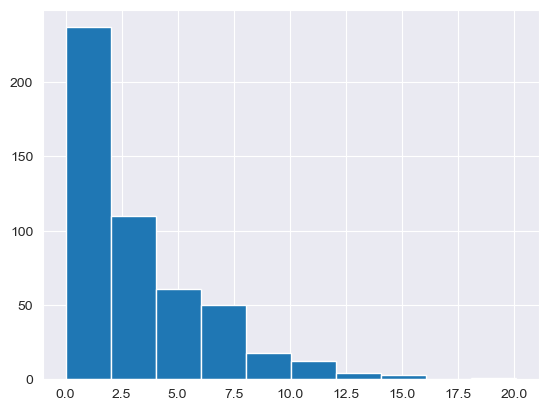

In [520]:
plt.hist(F_list)

In [525]:
count = 0
for F in F_list:
    if F > 10:
        count += 1
print(count/len(F_list)*100, '%')

4.032258064516129 %


In [465]:
df_tickers_copy = df_tickers.copy(deep=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Technology'),
  Text(1, 0, 'Consumer Cyclical'),
  Text(2, 0, 'Communication Services'),
  Text(3, 0, 'Healthcare'),
  Text(4, 0, 'Financial Services'),
  Text(5, 0, 'Energy'),
  Text(6, 0, 'Consumer Defensive'),
  Text(7, 0, 'Basic Materials'),
  Text(8, 0, 'Industrials'),
  Text(9, 0, 'Real Estate'),
  Text(10, 0, 'Utilities')])

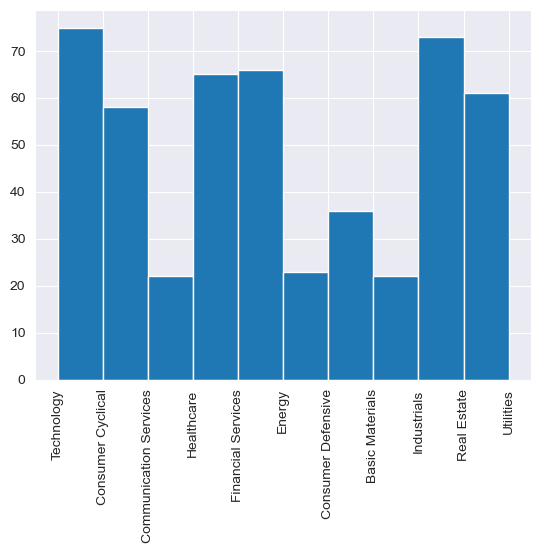

In [466]:
df_tickers_copy['sector'].hist()
plt.xticks(rotation=90)

In [467]:
df_tickers_copy = df_tickers_copy.set_index('Ticker')

In [468]:
betas = dict.fromkeys(tickers)
var_index = np.cov(data[['Return SPY', 'Return ' + ticker]].dropna()['Return SPY'], data[['Return SPY', 'Return ' + ticker]].dropna()['Return ' + ticker])[0][0]
for ticker in tickers:
    if ticker == 'SPY':
        betas[ticker] = 1
    else:
        betas[ticker] = np.cov(data[['Return SPY', 'Return ' + ticker]].dropna()['Return SPY'], data[['Return SPY', 'Return ' + ticker]].dropna()['Return ' + ticker])[0][1]/var_index

In [469]:
df_beta = pd.DataFrame.from_dict(betas, orient='index').reset_index()
df_beta.columns = ['Ticker', 'beta_calc']
df_tickers_copy = df_tickers_copy.reset_index()
df_tickers_copy = df_tickers_copy.merge(df_beta, on='Ticker', how='right')

df_MSE = pd.DataFrame.from_dict(result_meta_stocks['vanilla']['MSE_adj_length'], orient='index').reset_index()
df_MSE.columns = ['Ticker', 'MSE_vanilla']
df_tickers_copy = df_tickers_copy.merge(df_MSE, on='Ticker', how='left')

df_MSE_hm = pd.DataFrame.from_dict(result_meta_stocks['vanilla']['MSE_historical_mean_adj_length'], orient='index').reset_index()
df_MSE_hm.columns = ['Ticker', 'MSE_historical_mean']
df_tickers_copy = df_tickers_copy.merge(df_MSE_hm, on='Ticker', how='left')

df_MSE_iv_v1 = pd.DataFrame.from_dict(result_meta_stocks['iv_pred_v1']['MSE_adj_length'], orient='index').reset_index()
df_MSE_iv_v1.columns = ['Ticker', 'MSE_iv_v1']
df_tickers_copy = df_tickers_copy.merge(df_MSE_iv_v1, on='Ticker', how='left')

df_MSE_iv_v2 = pd.DataFrame.from_dict(result_meta_stocks['iv_pred_v2']['MSE_adj_length'], orient='index').reset_index()
df_MSE_iv_v2.columns = ['Ticker', 'MSE_iv_v2']
df_tickers_copy = df_tickers_copy.merge(df_MSE_iv_v2, on='Ticker', how='left')

In [470]:
df_tickers_copy.head()

,Ticker,sector,sectorKey,industry,beta,marketCap,beta_calc,MSE_vanilla,MSE_historical_mean,MSE_iv_v1,MSE_iv_v2
0,MSFT,Technology,technology,Software - Infrastructure,0.890,3.094184e+12,0.953661,0.001032,0.001043,0.001081,0.001034
1,AAPL,Technology,technology,Consumer Electronics,1.289,2.665581e+12,1.112560,0.001470,0.001450,0.001441,0.001469
2,NVDA,Technology,technology,Semiconductors,1.725,2.195913e+12,1.531838,0.003155,0.003162,0.003306,0.003456
3,AMZN,Consumer Cyclical,consumer-cyclical,Internet Retail,1.171,1.811770e+12,1.085465,0.001730,0.001724,0.001738,0.001730
4,META,Communication Services,communication-services,Internet Content & Information,1.208,1.234169e+12,0.984573,0.002417,0.002410,0.002507,0.002444


In [471]:
df_tickers_copy[['MSE_vanilla', 'MSE_historical_mean', 'MSE_iv_v1', 'MSE_iv_v2']] = np.sqrt(df_tickers_copy[['MSE_vanilla', 'MSE_historical_mean', 'MSE_iv_v1', 'MSE_iv_v2']])

In [472]:
df_tickers_copy = df_tickers_copy.rename(columns={'MSE_vanilla': 'RMSE_vanilla', 'MSE_historical_mean': 'RMSE_historical_mean', 'MSE_iv_v1': 'RMSE_iv_v1', 'MSE_iv_v2': 'RMSE_iv_v2'})

In [473]:
df_tickers_copy['Best performing model'] = df_tickers_copy[['RMSE_vanilla', 'RMSE_historical_mean', 'RMSE_iv_v1', 'RMSE_iv_v2']].apply(lambda x: 'AR1' if x[0] < x[1] and x[0] < x[2] and x[0] < x[3] else 'historical mean' if x[1] < x[0] and x[1] < x[2] and x[1] < x[3] else 'IV v1' if x[2] < x[0] and x[2] < x[1] and x[2] < x[3] else 'IV v2', axis=1)

<Axes: >

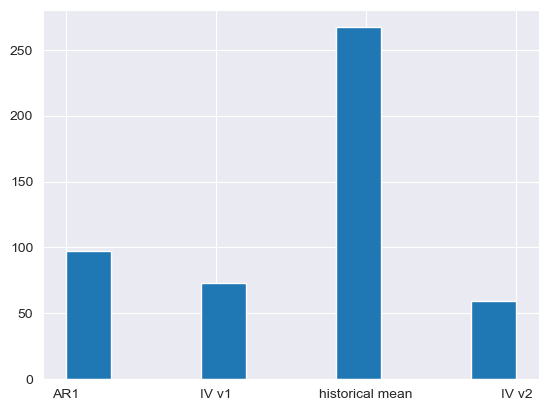

In [474]:
df_tickers_copy['Best performing model'].hist()

In [475]:
df_tickers_copy['sector'].value_counts()

sector
Technology                74
Industrials               72
Financial Services        66
Healthcare                63
Consumer Cyclical         57
Consumer Defensive        35
Real Estate               31
Utilities                 29
Energy                    23
Communication Services    22
Basic Materials           22
Name: count, dtype: int64

In [476]:
df_tickers_copy['industry'].value_counts()

industry
Utilities - Regulated Electric    23
Specialty Industrial Machinery    17
Semiconductors                    13
Software - Application            13
Diagnostics & Research            12
                                  ..
Food Distribution                  1
Rental & Leasing Services          1
Copper                             1
Consumer Electronics               1
Trucking                           1
Name: count, Length: 113, dtype: int64

<Axes: >

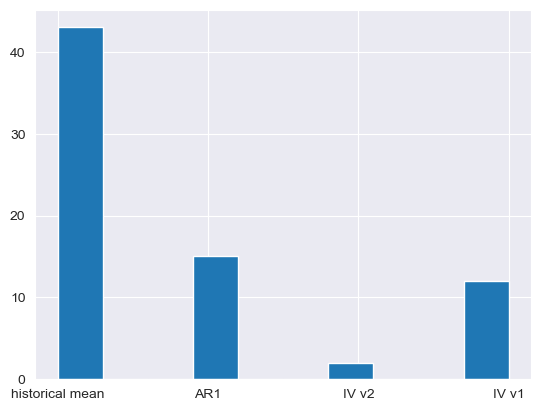

In [477]:
df_tickers_copy[df_tickers_copy['sector'] == 'Industrials']['Best performing model'].hist()

In [478]:
df_tickers_copy.head()

,Ticker,sector,sectorKey,industry,beta,marketCap,beta_calc,RMSE_vanilla,RMSE_historical_mean,RMSE_iv_v1,RMSE_iv_v2,Best performing model
0,MSFT,Technology,technology,Software - Infrastructure,0.890,3.094184e+12,0.953661,0.032128,0.032292,0.032884,0.032151,AR1
1,AAPL,Technology,technology,Consumer Electronics,1.289,2.665581e+12,1.112560,0.038334,0.038085,0.037957,0.038332,IV v1
2,NVDA,Technology,technology,Semiconductors,1.725,2.195913e+12,1.531838,0.056169,0.056235,0.057495,0.058785,AR1
3,AMZN,Consumer Cyclical,consumer-cyclical,Internet Retail,1.171,1.811770e+12,1.085465,0.041598,0.041522,0.041686,0.041596,historical mean
4,META,Communication Services,communication-services,Internet Content & Information,1.208,1.234169e+12,0.984573,0.049164,0.049093,0.050071,0.049433,historical mean


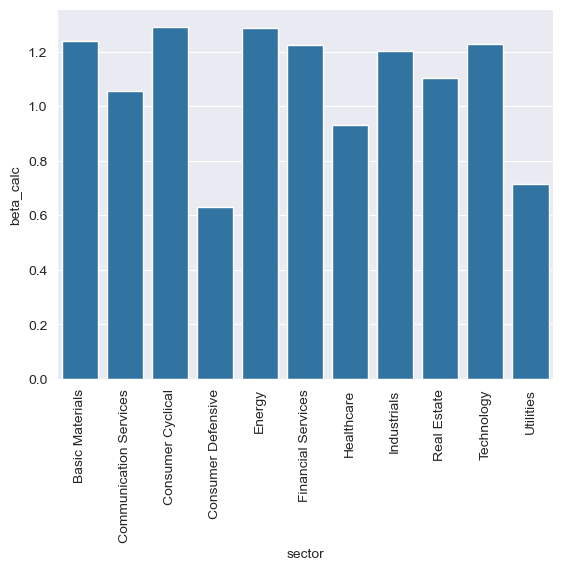

In [479]:
temp = df_tickers_copy[['sector', 'beta_calc']].groupby(by='sector').mean().reset_index()
sns.barplot(temp, x='sector', y='beta_calc')
plt.xticks(rotation=90)
plt.show()

In [480]:
df_tickers_copy_percentage = df_tickers_copy.groupby(by=['sector', 'Best performing model'])['Ticker'].count()/df_tickers_copy.groupby(by=['sector'])['Ticker'].count()*100
df_tickers_copy_percentage = pd.DataFrame(df_tickers_copy_percentage).rename(columns={'Ticker': 'Percentage of stocks in the industry'})
df_tickers_copy_percentage.head(7)

Percentage of stocks in the industry
sector                 Best performing model                                      
Basic Materials        AR1                                               22.727273
                       IV v1                                             18.181818
                       IV v2                                              4.545455
                       historical mean                                   54.545455
Communication Services AR1                                               18.181818
                       IV v1                                             27.272727
                       IV v2                                             13.636364

<Axes: xlabel='Best performing model', ylabel='Percentage of stocks in the industry'>

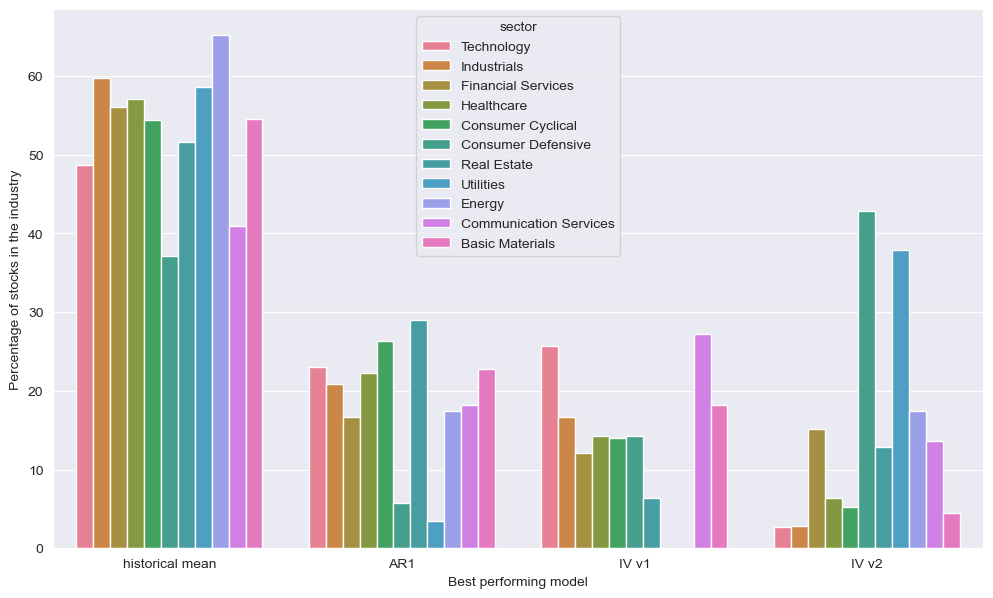

In [482]:
plt.figure(figsize=(12, 7)) # in the percentage within a sector
sns.barplot(df_tickers_copy_percentage, x='Best performing model', y='Percentage of stocks in the industry', hue='sector', order=list(df_tickers_copy['Best performing model'].value_counts().index)
, hue_order=list(df_tickers_copy['sector'].value_counts().index
))

<Axes: xlabel='Best performing model', ylabel='Percentage of stocks in the industry'>

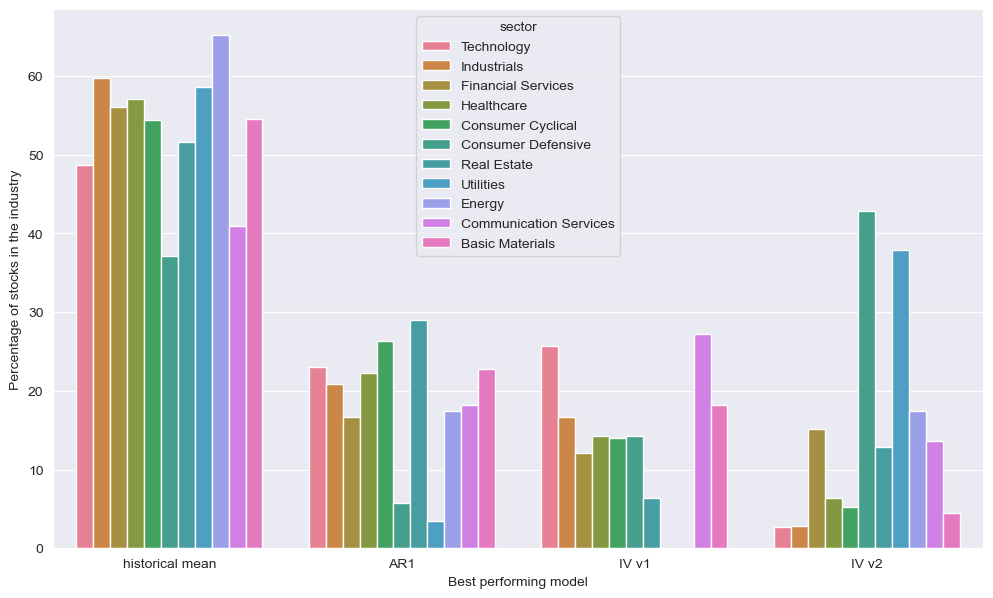

In [483]:
plt.figure(figsize=(12, 7)) # in the percentage within a sector
sns.barplot(df_tickers_copy_percentage, x='Best performing model', y='Percentage of stocks in the industry', hue='sector', order=list(df_tickers_copy['Best performing model'].value_counts().index)
, hue_order=list(df_tickers_copy['sector'].value_counts().index
))

<Axes: xlabel='Best performing model', ylabel='percent'>

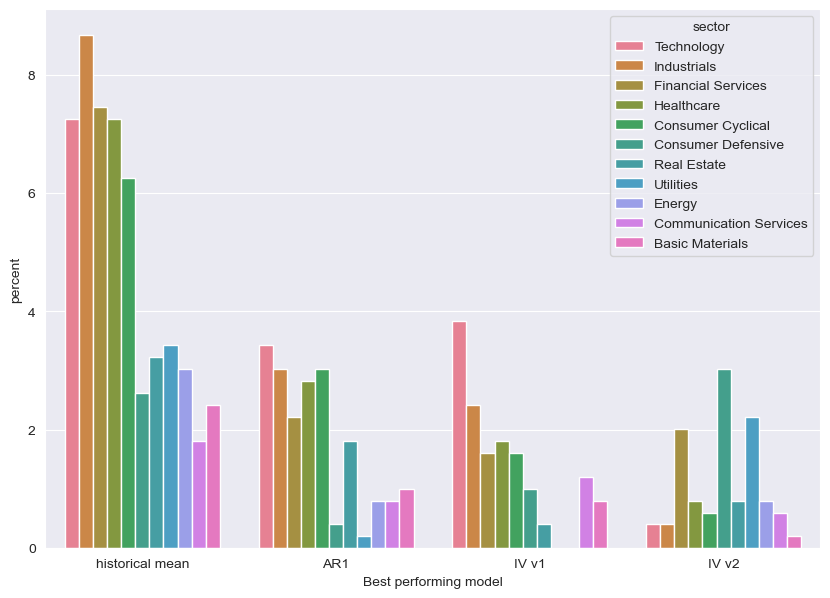

In [485]:
plt.figure(figsize=(10, 7)) # in percentage of the overall number of stocks
sns.countplot(data=df_tickers_copy, x="Best performing model", hue="sector", order=list(df_tickers_copy['Best performing model'].value_counts().index),
              hue_order=list(df_tickers_copy['sector'].value_counts().index), stat='percent')

In [486]:
df_tickers_copy[['RMSE_vanilla', 'RMSE_historical_mean', 'RMSE_iv_v1', 'RMSE_iv_v2']].mean(axis=0)

RMSE_vanilla            0.042011
RMSE_historical_mean    0.041823
RMSE_iv_v1              0.042339
RMSE_iv_v2              0.042254
dtype: float64

In [487]:
# one-sample dependent two-sided alternative t-test for to find any significant differences between models
for ticker in tickers:
    # print(ticker)
    if ticker == 'SPY':
        continue
    start_idx = len(result_meta_stocks['vanilla']['errors'][ticker]) - len(result_meta_stocks['iv_pred_v1']['errors'][ticker])
    assert len(result_meta_stocks['vanilla']['errors'][ticker]['Error'].iloc[start_idx:]) == len(result_meta_stocks['iv_pred_v1']['errors'][ticker]['Error'])
    d = np.array(result_meta_stocks['vanilla']['errors'][ticker]['Error'].iloc[start_idx:])**2 - np.array(result_meta_stocks['iv_pred_v1']['errors'][ticker]['Error'])**2
    mean = np.mean(d)
    sd = np.std(d)
    n = len(result_meta_stocks['vanilla']['errors'][ticker]['Error'].iloc[start_idx:])
    t_stat = mean/(sd/np.sqrt(n))
    p_value = 2*(1 - stats.t.cdf(abs(t_stat), n-1))
    if p_value < 0.05:
        print(ticker, df_tickers_copy.loc[df_tickers_copy['Ticker'] == ticker]['sector'].iloc[0], '\n', t_stat, p_value)
        print(stats.ttest_rel(np.array(result_meta_stocks['vanilla']['errors'][ticker]['Error'].iloc[start_idx:])**2, np.array(result_meta_stocks['iv_pred_v1']['errors'][ticker]['Error'])**2))
        print('Length of data:', len(data['Return ' + ticker].dropna()), '\n', 'Length of the whole dataframe (data):', len(data))
        print('\n-------------------------\n')

TSLA Consumer Cyclical 
 -3.0825945964005435 0.0021615502723264512
TtestResult(statistic=-3.079617681561855, pvalue=0.0021828718210428486, df=517)
Length of data: 714 
 Length of the whole dataframe (data): 781

-------------------------

V Financial Services 
 -2.1186613086795885 0.034540674831785134
TtestResult(statistic=-2.116849712530718, pvalue=0.03469484269029513, df=584)
Length of data: 781 
 Length of the whole dataframe (data): 781

-------------------------

SBUX Consumer Cyclical 
 -2.3359443560172943 0.019831607288840036
TtestResult(statistic=-2.3339469684301424, pvalue=0.019936757573726187, df=584)
Length of data: 781 
 Length of the whole dataframe (data): 781

-------------------------

MDLZ Consumer Defensive 
 2.1494383943278543 0.03200982713910294
TtestResult(statistic=2.147600481726418, pvalue=0.03215635804870509, df=584)
Length of data: 781 
 Length of the whole dataframe (data): 781

-------------------------

GILD Healthcare 
 -2.364028189212091 0.0184037551288711

In [490]:
# one-sample dependent one-sided alternative t-test for to find any significant differences between models
for ticker in tickers:
    start_idx = len(result_meta_stocks['vanilla']['errors'][ticker]) - len(result_meta_stocks['iv_pred_v1']['errors'][ticker])
    assert len(result_meta_stocks['vanilla']['errors'][ticker]['Error'].iloc[start_idx:]) == len(result_meta_stocks['iv_pred_v1']['errors'][ticker]['Error'])
    test = stats.ttest_rel(np.array(result_meta_stocks['iv_pred_v1']['errors'][ticker]['Error'])**2, np.array(result_meta_stocks['vanilla']['errors'][ticker]['Error'].iloc[start_idx:])**2, alternative='less')
    if test[1] < 0.05:
        print(ticker, df_tickers_copy.loc[df_tickers_copy['Ticker'] == ticker]['sector'].iloc[0], '\n', test)
        print('RMSE iv_pred_v1: ', np.sqrt(result_meta_stocks['iv_pred_v1']['MSE_adj_length'][ticker]), '\nRMSE vanilla: ', np.sqrt(result_meta_stocks['vanilla']['MSE_adj_length'][ticker]), '\nDifference: ', np.sqrt(result_meta_stocks['iv_pred_v1']['MSE_adj_length'][ticker]) - np.sqrt(result_meta_stocks['vanilla']['MSE_adj_length'][ticker]))
        print('Length of data:', len(data['Return ' + ticker].dropna()), '\nLength of the whole dataframe (data):', len(data))
        print('\n--------------------\n')

MDLZ Consumer Defensive 
 TtestResult(statistic=-2.147600481726418, pvalue=0.016078179024352546, df=584)
RMSE iv_pred_v1:  0.028240217641818742 
RMSE vanilla:  0.03729381853428107 
Difference:  -0.009053600892462328
Length of data: 781 
Length of the whole dataframe (data): 781

--------------------

BG Consumer Defensive 
 TtestResult(statistic=-1.7923824037799894, pvalue=0.036794607159253916, df=584)
RMSE iv_pred_v1:  0.0374224815321941 
RMSE vanilla:  0.03695546164228122 
Difference:  0.00046701988991287857
Length of data: 781 
Length of the whole dataframe (data): 781

--------------------


In [440]:
len(tickers)

497

In [345]:
result_meta_stocks['iv_pred_v1']['errors']['ABNB']['Date'].min(), result_meta_stocks['iv_pred_v1']['errors']['ABNB']['Date'].max()

(Timestamp('2022-11-14 00:00:00'), Timestamp('2024-03-25 00:00:00'))

In [301]:
# def diff_lists(list1, list2):
#     if len(list1) == len(list2):
#         res = [np.NaN]*len(list1)
#         for i in range(0, len(list1)):
#             res[i] = list1[i] - list2[i]
#         return res
#     else:
#         print('diff_lists function: Different lengths Warning')
#         l = min(len(list1), len(list2))
#         d = abs(len(list2) - len(list1))
#         if len(list1) < len(list2):
#             list1 = [np.NaN]*d + list1
#         else:
#             list2 = [np.NaN]*d + list2
#         res = [np.NaN]*min(len(list1), len(list2))
#         for i in range(0, len(list1)):
#             res[i] = list1[i] - list2[i]
#         return res

def diff_errors_dataframes(df1, df2):
    df3 = df1.join(df2.set_index('Date'), on='Date', how='outer', rsuffix='_r')
    df3['Diff'] = df3['Error'] - df3['Error_r']
    return df3[['Date', 'Diff']].dropna()
        
        
        
def plot_errors(result_meta_stocks, step1, step2, ticker):
    errors_vanilla = result_meta_stocks[step1]['errors'][ticker]
    errors_iv = result_meta_stocks[step2]['errors'][ticker]
    # print(errors_vanilla)
    # print('\n\n\n\n\n\n\n\n\n\n', errors_iv)
    # print(len(errors_vanilla), len(errors_iv))
  
    if step2 == 'iv_pred_v1':
        step3 = 'iv_pred_v2'
    elif step2 == 'iv_pred_v2':
        step3 = 'iv_pred_v1'
        
    fig1 = plt.figure(figsize=(20, 3))
    plt.plot(errors_vanilla['Date'], errors_vanilla['Error'])
    plt.title('Errors ' + step1)
    
    fig2 = plt.figure(figsize=(20, 3))
    plt.plot(errors_iv['Date'], errors_iv['Error'])
    plt.title('Errors ' + step2)
    
    fig3 = plt.figure(figsize=(20, 3))
    plt.plot(result_meta_stocks[step3]['errors'][ticker]['Date'], result_meta_stocks[step3]['errors'][ticker]['Error'])
    plt.title('Errors ' + step3)

    fig4 = plt.figure(figsize=(20, 3))
    df_diff = diff_errors_dataframes(errors_vanilla, errors_iv)
    plt.plot(df_diff['Date'], df_diff['Diff']) # difference of errors with time
    plt.title('Difference in errors ' + step1 + ' - ' + step2)    
    
    fig5 = plt.figure(figsize=(20, 3))
    df_diff = diff_errors_dataframes(errors_vanilla, result_meta_stocks[step3]['errors'][ticker])
    plt.plot(df_diff['Date'], df_diff['Diff']) # difference of errors with time
    plt.title('Difference in errors ' + step1 + ' - ' + step3)    

    fig6 = plt.figure(figsize=(20, 3))
    df_diff_ivs = diff_errors_dataframes(errors_iv, result_meta_stocks[step3]['errors'][ticker])
    plt.plot(df_diff_ivs['Date'], abs(df_diff_ivs['Diff']))
    plt.title('Abs difference in errors ' + step2 + ' - ' + step3)
    
    fig7 = plt.figure(figsize=(20, 3))
    plt.plot(errors_iv['Date'], errors_iv['Error'], linewidth=1)
    plt.plot(result_meta_stocks[step3]['errors'][ticker]['Date'], result_meta_stocks[step3]['errors'][ticker]['Error'], linewidth=1)
    plt.title('Errors ' + step2 + ' and ' + step3)

    
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].hist(errors_vanilla['Error'], bins=15)
    ax[1].hist(errors_iv['Error'].to_list(), bins=15)
    
    fig = sm.qqplot(np.array(errors_iv['Error']), fit=True, line='45')
    
    plt.show()
    
    print("Shapiro-Wilk test for vanilla and iv residuals normality:\nReg: ", shapiro(errors_vanilla['Error'].to_list()), "\nIV: ", shapiro(errors_iv['Error'].to_list()))
    print("\nt-test for residual means: ", scipy.stats.ttest_ind(errors_vanilla['Error'].to_list(), errors_iv['Error'].to_list(), equal_var = False))
    
# def errors_statistic(result_meta_stocks, ticker):

In [302]:
%matplotlib inline

In [433]:
average MSE w stocks each year, which model is best perfoming

SyntaxError: invalid syntax (921832575.py, line 1)

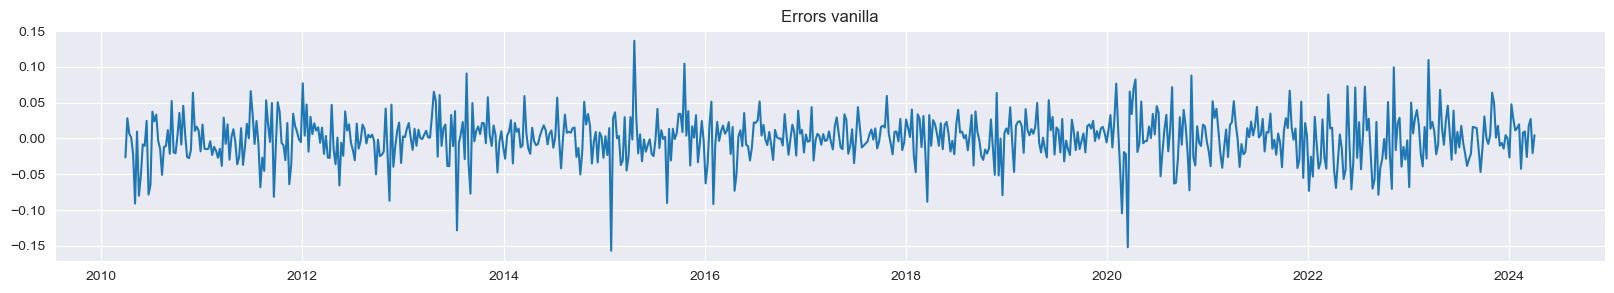

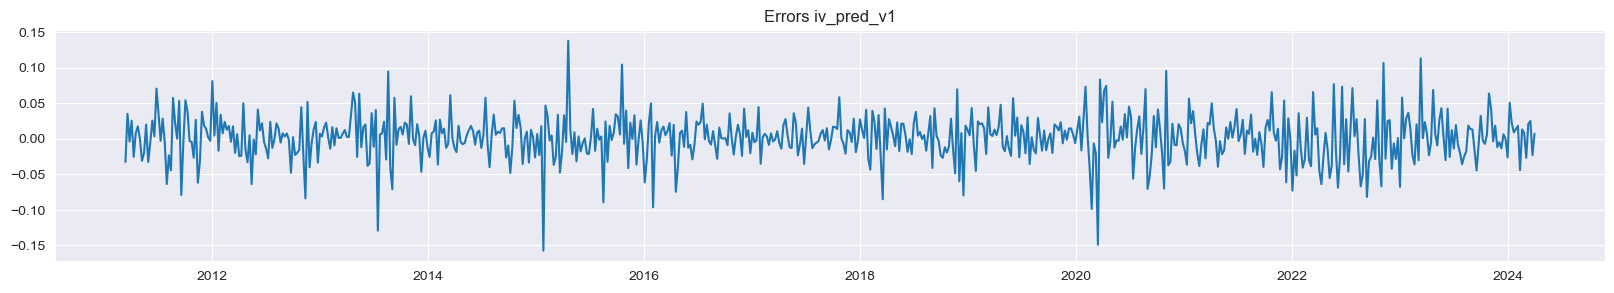

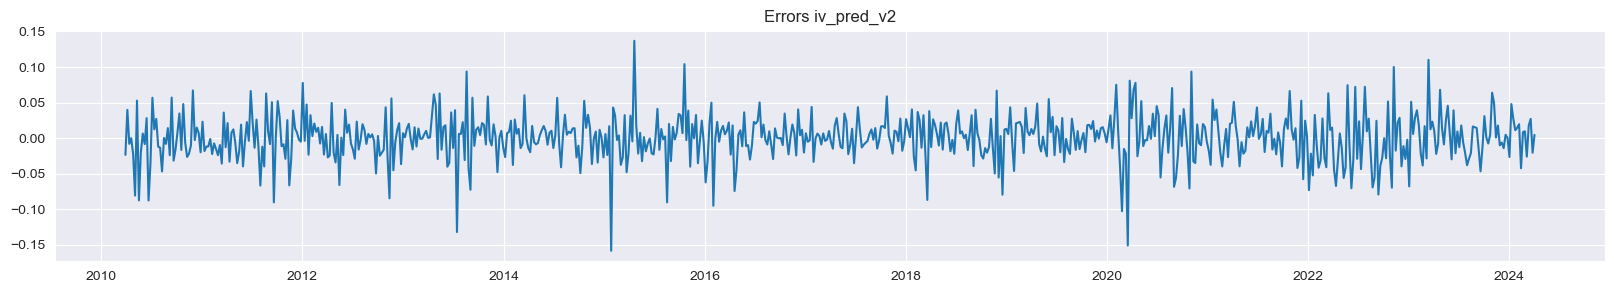

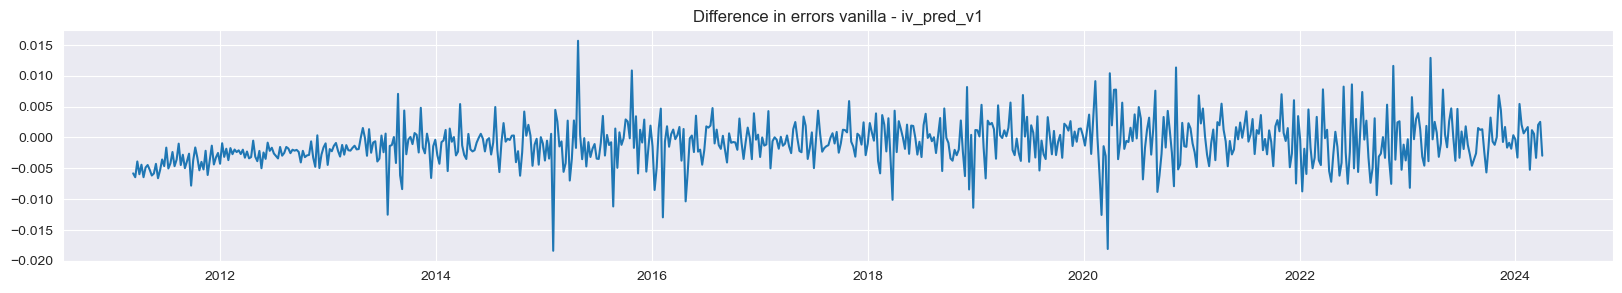

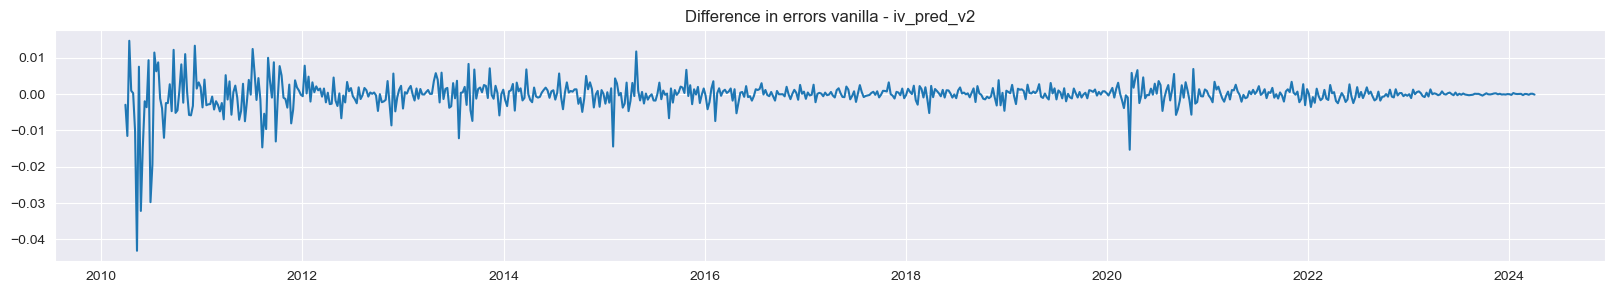

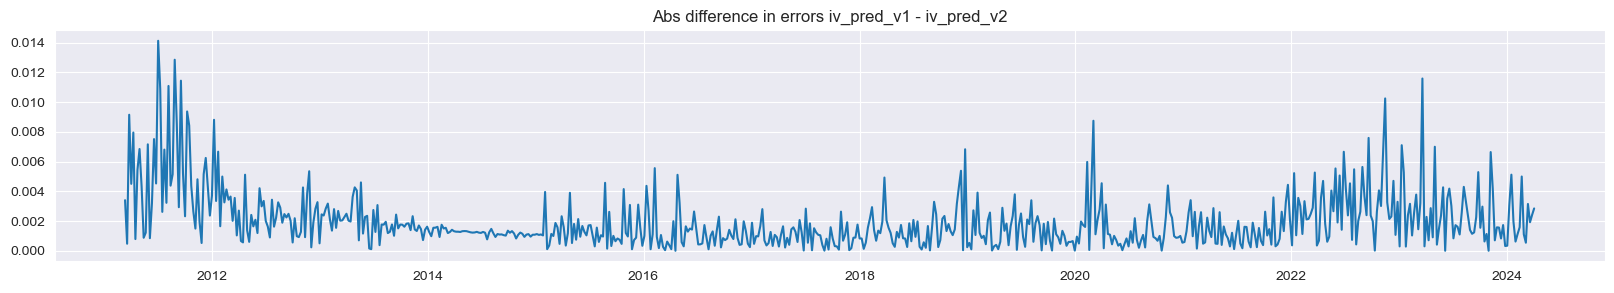

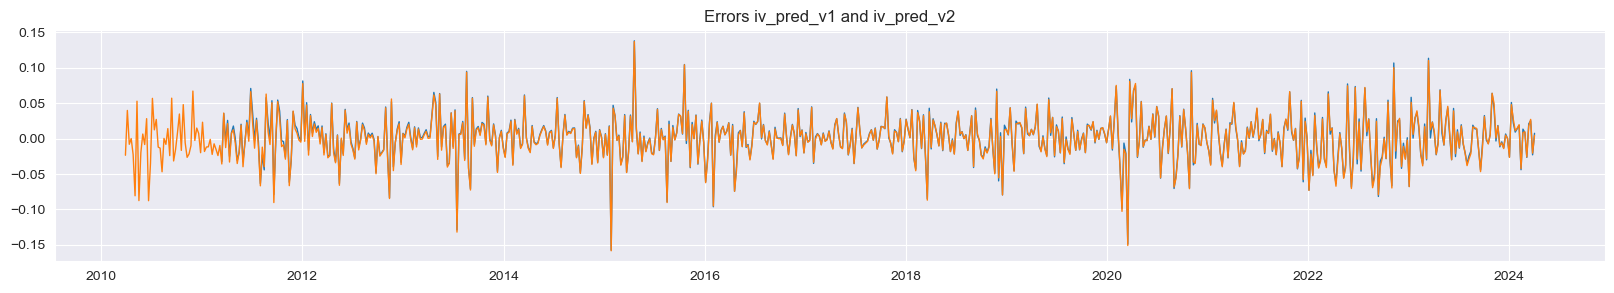

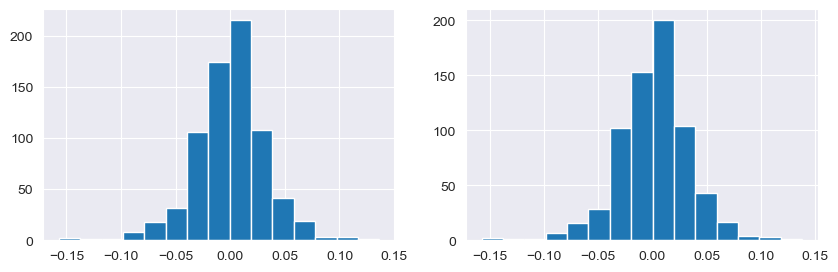

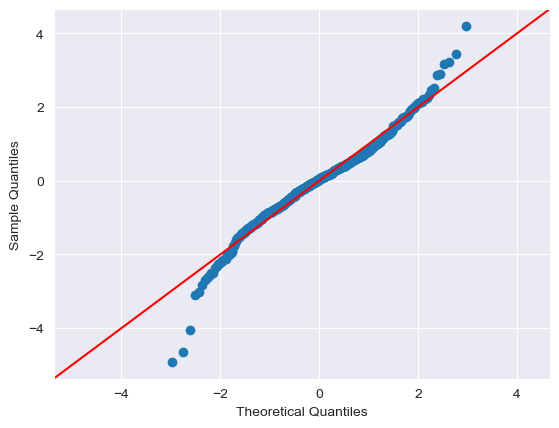

Shapiro-Wilk test for vanilla and iv residuals normality:
Reg:  ShapiroResult(statistic=0.9729912426708074, pvalue=2.2333814551167442e-10) 
IV:  ShapiroResult(statistic=0.9715005767215157, pvalue=2.9633952700534134e-10)

t-test for residual means:  TtestResult(statistic=-0.8889657764233075, pvalue=0.37417376352992016, df=1403.8946710992886)


In [432]:
plot_errors(result_meta_stocks, step1='vanilla', step2='iv_pred_v1', ticker='MSFT')

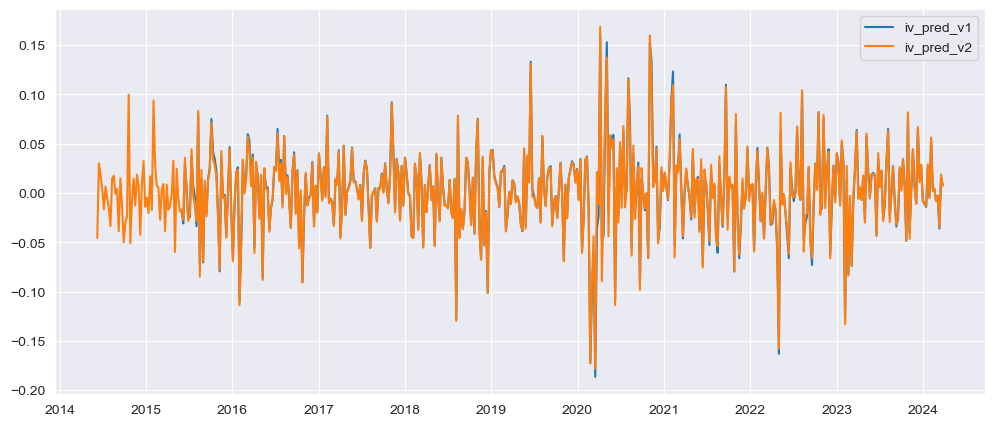

In [306]:
%matplotlib inline
fig = plt.figure(figsize=(12, 5))
plt.plot(result_meta_stocks['iv_pred_v1']['errors'][ticker]['Date'], result_meta_stocks['iv_pred_v1']['errors'][ticker]['Error'], label='iv_pred_v1')
plt.plot(result_meta_stocks['iv_pred_v2']['errors'][ticker]['Date'], result_meta_stocks['iv_pred_v2']['errors'][ticker]['Error'], label='iv_pred_v2')
plt.legend()

In [323]:
result_meta_stocks['iv_pred_v1']['errors'][ticker]['Date'].min()

Timestamp('2015-05-25 00:00:00')

In [322]:
result_meta_stocks['iv_pred_v2']['errors'][ticker]

,Date,Error
0,2014-06-09,-0.045583
1,2014-06-16,0.030164
2,2014-06-23,0.018920
3,2014-06-30,0.004634
4,2014-07-07,-0.016626
...,...,...
507,2024-02-26,-0.008130
508,2024-03-04,-0.002429
509,2024-03-11,-0.034794
510,2024-03-18,0.018725


In [331]:
np.array(result_meta_stocks['iv_pred_v2']['errors'][ticker].loc[result_meta_stocks['iv_pred_v2']['errors'][ticker]['Date'] >= result_meta_stocks['iv_pred_v1']['errors'][ticker]['Date'].min(), 'Error'])

array([3.59005077e-04, 2.76978450e-04, 7.30301414e-04, 1.27042923e-03,
       7.18796862e-06, 8.09922753e-04, 4.02100759e-04, 1.96160300e-03,
       5.61587710e-06, 1.39660296e-04, 7.80538920e-04, 6.92486708e-03,
       7.19466490e-03, 5.36846684e-04, 4.74436998e-03, 1.60044188e-04,
       5.55355133e-04, 1.75680107e-04, 5.06134057e-04, 5.11003314e-03,
       1.17468981e-03, 7.94173111e-04, 3.17361398e-04, 6.27289220e-04,
       6.06434805e-03, 1.81212144e-03, 2.52069734e-05, 1.10520907e-05,
       2.07544460e-03, 1.22692837e-06, 2.02647491e-03, 4.24340091e-04,
       4.76709444e-03, 1.08660532e-04, 4.12056894e-04, 5.63530377e-04,
       1.29398363e-02, 2.65260275e-03, 1.15137851e-03, 2.28517540e-07,
       2.23745358e-04, 3.20942238e-03, 2.01957302e-03, 4.39030966e-05,
       1.29684554e-03, 3.70151015e-03, 1.00093610e-03, 2.04653107e-04,
       6.83436995e-04, 3.40935849e-04, 7.77738826e-03, 6.38641104e-04,
       1.77099578e-05, 1.23943857e-05, 1.54956715e-03, 1.90391373e-04,
      

In [335]:
mses = []
for ticker in tickers:
    date = result_meta_stocks['iv_pred_v1']['errors'][ticker]['Date'].min()
    temp = result_meta_stocks['iv_pred_v2']['errors'][ticker].loc[result_meta_stocks['iv_pred_v2']['errors'][ticker]['Date'] >= date, 'Error']
    mses.append(np.sum(np.array(temp)**2)/len(temp))

In [337]:
np.mean(mses)

0.001995262517846697

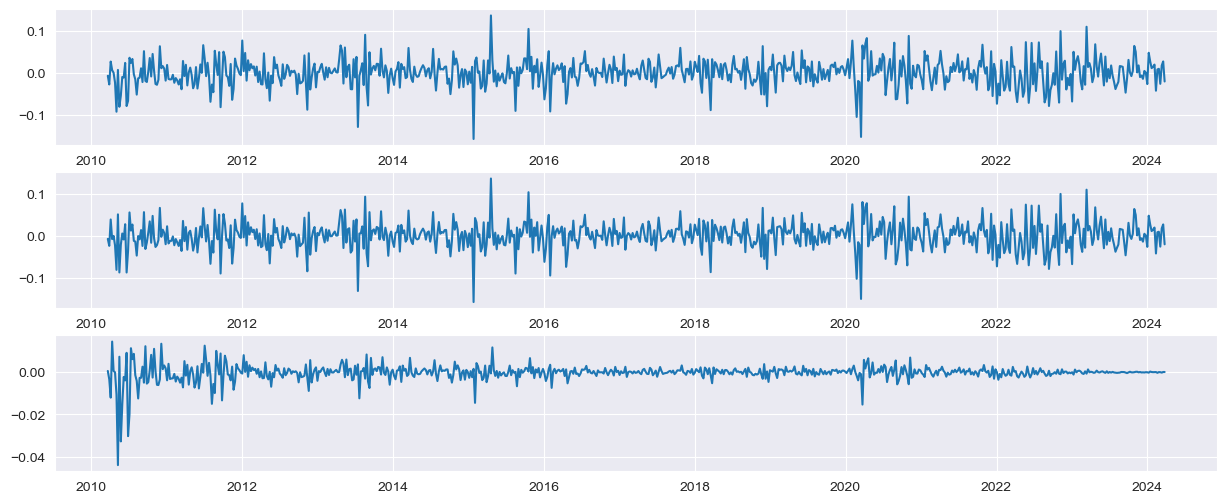

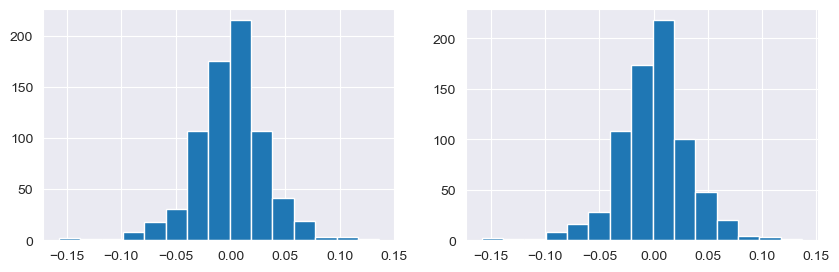

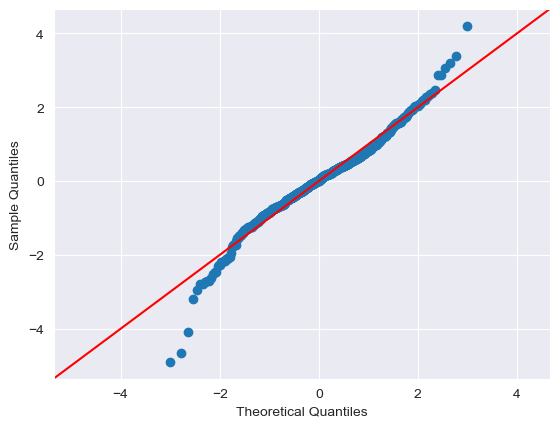

Shapiro-Wilk test for vanilla and iv residuals normality:
Reg:  ShapiroResult(statistic=0.973079486228305, pvalue=2.350432986416808e-10) 
IV:  ShapiroResult(statistic=0.9722992215227796, pvalue=1.5015504046324977e-10)

t-test for residual means:  TtestResult(statistic=-0.10065709511632714, pvalue=0.9198364731691635, df=1461.9488748835126)


In [239]:
plot_errors(result_meta_stocks, step1='vanilla', step2='iv_pred_v2', ticker='MSFT')

In [150]:
significance = 0.05 # loop to find tickers with significant difference in errors in vanilla vs v1
tickers_with_significant_difference_in_errors = []
for ticker in tickers:
    if ticker == "SPY":
        continue
    if scipy.stats.ttest_ind(result_meta_stocks['vanilla']['errors'][ticker]['Error'].to_list(), result_meta_stocks['iv_pred_v1']['errors'][ticker]['Error'].to_list(), equal_var = False)[1] < significance: # False - Welch’s t-test, does not assume equal population variance /\ sample sizes
        tickers_with_significant_difference_in_errors.append(ticker)
print(tickers_with_significant_difference_in_errors)

['TMUS', 'CARR', 'AVB', 'FITB', 'EQR', 'LVS', 'HBAN', 'INCY']


In [65]:
significance = 0.05 # loop to find tickers with significant difference in errors in vanilla vs v2
tickers_with_significant_difference_in_errors = []
for ticker in tickers:
    if ticker == "SPY":
        continue
    if scipy.stats.ttest_ind(result_meta_stocks['vanilla']['errors'][ticker]['Error'].to_list(), result_meta_stocks['iv_pred_v2']['errors'][ticker]['Error'].to_list(), equal_var = False)[1] < significance: # False - Welch’s t-test, does not assume equal population variance
        tickers_with_significant_difference_in_errors.append(ticker)
print(tickers_with_significant_difference_in_errors)

[]


(array([187., 167.,  73.,  31.,  18.,  10.,   6.,   0.,   2.,   1.,   0.,
          0.,   0.,   2.,   1.]),
 array([0.00049651, 0.0013586 , 0.0022207 , 0.0030828 , 0.0039449 ,
        0.00480699, 0.00566909, 0.00653119, 0.00739328, 0.00825538,
        0.00911748, 0.00997957, 0.01084167, 0.01170377, 0.01256586,
        0.01342796]),
 <BarContainer object of 15 artists>)

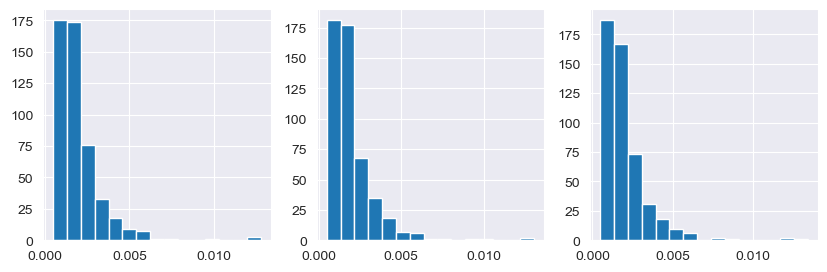

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].hist(list(result_meta_stocks['vanilla']['MSE'].values()), bins=15)
ax[1].hist(list(result_meta_stocks['iv_pred_v1']['MSE'].values()), bins=15)
ax[2].hist(list(result_meta_stocks['iv_pred_v2']['MSE'].values()), bins=15)

In [415]:
print('MSE mean average for AR1: ', np.mean(list(result_meta_stocks['vanilla']['MSE'].values())))
print('MSE mean average for AR1 IV v1: ', np.mean(list(result_meta_stocks['iv_pred_v1']['MSE'].values())))
print('MSE mean average for AR1 IV v2: ', np.mean(list(result_meta_stocks['iv_pred_v2']['MSE'].values())))

MSE mean average for AR1:  0.0019678034716035897
MSE mean average for AR1 IV v1:  0.0019676111188853124
MSE mean average for AR1 IV v2:  0.002006401834099703


In [67]:
print('MSE mean average for AR1: ', np.mean(list(result_meta_stocks['vanilla']['MSE'].values())))
print('MSE mean average for AR1 IV v1: ', np.mean(list(result_meta_stocks['iv_pred_v1']['MSE'].values())))
print('MSE mean average for AR1 IV v2: ', np.mean(list(result_meta_stocks['iv_pred_v2']['MSE'].values())))

MSE mean average for AR1:  0.0019667894210338675
MSE mean average for AR1 IV v1:  0.001966980774801377
MSE mean average for AR1 IV v2:  0.002006403122862559


In [141]:
print('RMSE mean adj length average for historical mean: ', np.mean(np.sqrt(list(result_meta_stocks['vanilla']['MSE_historical_mean_adj_length'].values()))))
print('RMSE mean adj length average for AR1: ', np.mean(np.sqrt(list(result_meta_stocks['vanilla']['MSE_adj_length'].values()))))
print('RMSE mean adj length average for AR1 IV v1: ', np.mean(np.sqrt(list(result_meta_stocks['iv_pred_v1']['MSE_adj_length'].values()))))
print('RMSE mean adj length average for AR1 IV v2: ', np.mean(np.sqrt(list(result_meta_stocks['iv_pred_v2']['MSE_adj_length'].values()))))

RMSE mean adj length average for historical mean:  0.042242228240861775
RMSE mean adj length average for AR1:  0.04242324895501259
RMSE mean adj length average for AR1 IV v1:  0.042428958881308376
RMSE mean adj length average for AR1 IV v2:  0.0426701218576261


In [70]:
print(stats.mannwhitneyu(list(result_meta_stocks['vanilla']['MSE'].values()), list(result_meta_stocks['iv_pred_v1']['MSE'].values())))
print(stats.mannwhitneyu(list(result_meta_stocks['vanilla']['MSE'].values()), list(result_meta_stocks['iv_pred_v2']['MSE'].values())))

MannwhitneyuResult(statistic=123723.0, pvalue=0.9510777339171048)
MannwhitneyuResult(statistic=122241.5, pvalue=0.698217857739258)


### Save Everything

In [142]:
with open('result_meta_stocks.pkl', 'wb') as f:
    pickle.dump(result_meta_stocks, f)

df_tickers_copy.to_csv("df_tickers_copy.csv")
data.to_csv("data.csv")

In [143]:
with open('tickers_list.pkl', 'wb') as f:
    pickle.dump(tickers, f)

### Futures, Currencies

In [526]:
df_AD = pd.read_csv('data/AD_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "AD"})
df_BP = pd.read_csv('data/BP_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "BP"})
df_CD = pd.read_csv('data/CD_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "CD"})
df_EU = pd.read_csv('data/EU_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "EU"})
df_JY = pd.read_csv('data/JY_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "JY"})
df_SF = pd.read_csv('data/SF_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "SF"})
df_CL = pd.read_csv('data/CL_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "CL"})
df_NG = pd.read_csv('data/NG_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "NG"})
df_GC = pd.read_csv('data/GC_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "GC"})
df_SI = pd.read_csv('data/SI_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "SI"})
df_ES = pd.read_csv('data/ES_D.csv', header=None)[[0, 4]].rename(columns={0: "Date", 4: "ES"})


# AD – Australian dollar
# BP – British pound
# CD – Canadian dollar
# EU – Euro
# JY – Japanese yen
# SF – Swiss Franc
# CL – Crude oil
# NG – Natural gas
# GC – Gold
# SI – Silver

In [527]:
df_AD['Date'] = pd.to_datetime(df_AD['Date'])
df_BP['Date'] = pd.to_datetime(df_BP['Date'])
df_CD['Date'] = pd.to_datetime(df_CD['Date'])
df_EU['Date'] = pd.to_datetime(df_EU['Date'])
df_JY['Date'] = pd.to_datetime(df_JY['Date'])
df_SF['Date'] = pd.to_datetime(df_SF['Date'])
df_CL['Date'] = pd.to_datetime(df_CL['Date'])
df_NG['Date'] = pd.to_datetime(df_NG['Date'])
df_GC['Date'] = pd.to_datetime(df_GC['Date'])
df_SI['Date'] = pd.to_datetime(df_SI['Date'])
df_ES['Date'] = pd.to_datetime(df_ES['Date'])

In [528]:
df_AD.head()

,Date,AD
0,1995-08-11,0.3685
1,1995-08-14,0.3685
2,1995-08-15,0.3685
3,1995-08-16,0.3685
4,1995-08-17,0.3685


In [529]:
print(df_AD.dtypes)

Date    datetime64[ns]
AD             float64
dtype: object


In [530]:
tickers_fc = ['AD', 'BP', 'CD', 'EU', 'JY', 'SF', 'CL', 'NG', 'GC', 'SI', 'ES']

In [531]:
df_AD = df_AD.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_BP = df_BP.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_CD = df_CD.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_EU = df_EU.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_JY = df_JY.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_SF = df_SF.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_CL = df_CL.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_NG = df_NG.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_GC = df_GC.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_SI = df_SI.groupby(pd.Grouper(key="Date", freq="1W")).last()
df_ES = df_ES.groupby(pd.Grouper(key="Date", freq="1W")).last()

In [532]:
df_fc = pd.merge(df_AD, df_BP, on='Date', how='outer').merge(df_CD, on='Date', how='outer').merge(df_EU, on='Date', how='outer').merge(df_JY, on='Date', how='outer').merge(df_SF, on='Date', how='outer').merge(df_CL, on='Date', how='outer').merge(df_NG, on='Date', how='outer').merge(df_GC, on='Date', how='outer').merge(df_SI, on='Date', how='outer').merge(df_ES, on='Date', how='outer')

In [533]:
df_fc = df_fc.reset_index()
df_fc.head()

,Date,AD,BP,CD,EU,JY,SF,CL,NG,GC,SI,ES
0,1983-04-03,NaN,NaN,NaN,NaN,NaN,NaN,52.58,NaN,NaN,NaN,NaN
1,1983-04-10,NaN,NaN,NaN,NaN,NaN,NaN,53.67,NaN,NaN,NaN,NaN
2,1983-04-17,NaN,NaN,NaN,NaN,NaN,NaN,53.77,NaN,NaN,NaN,NaN
3,1983-04-24,NaN,NaN,NaN,NaN,NaN,NaN,54.04,NaN,NaN,NaN,NaN
4,1983-05-01,NaN,NaN,NaN,NaN,NaN,NaN,53.92,NaN,NaN,NaN,NaN


In [534]:
df_fc = df_fc.loc[df_fc['Date'].dt.date > (df_fc.Date.max() - relativedelta(years=15)).date()]
df_fc.head()

,Date,AD,BP,CD,EU,JY,SF,CL,NG,GC,SI,ES
1354,2009-03-15,0.4614,1.4499,0.7672,1.46455,0.011975,1.09285,90.31,15.821,1229.4,19.169,736.5
1355,2009-03-22,0.4905,1.4964,0.7891,1.52965,0.012188,1.13655,95.25,16.116,1255.5,19.794,746.0
1356,2009-03-29,0.4960,1.4830,0.7909,1.50495,0.011967,1.12635,95.56,15.531,1222.5,19.217,798.0
1357,2009-04-05,0.5213,1.5349,0.7953,1.52325,0.011740,1.13475,95.69,15.595,1196.6,18.689,822.5
1358,2009-04-12,0.5216,1.5156,0.7967,1.48875,0.011719,1.11445,95.42,15.404,1182.6,18.284,834.5


In [535]:
df_fc[['Return ' + ticker for ticker in tickers_fc]] = np.log(df_fc[tickers_fc]).diff()

In [536]:
df_fc = df_fc.drop(columns=tickers_fc)

In [537]:
df_fc.isna().sum()

Date         0
Return AD    1
Return BP    1
Return CD    1
Return EU    1
Return JY    1
Return SF    1
Return CL    1
Return NG    1
Return GC    1
Return SI    1
Return ES    1
dtype: int64

In [538]:
df_fc = df_fc.dropna()
df_fc = df_fc.reset_index().drop(columns='index')
df_fc.head()

,Date,Return AD,Return BP,Return CD,Return EU,Return JY,Return SF,Return CL,Return NG,Return GC,Return SI,Return ES
0,2009-03-22,0.061160,0.031568,0.028146,0.043491,0.017631,0.039208,0.053257,0.018474,0.021008,0.032084,0.012816
1,2009-03-29,0.011151,-0.008995,0.002278,-0.016279,-0.018299,-0.009015,0.003249,-0.036975,-0.026636,-0.029584,0.067383
2,2009-04-05,0.049750,0.034398,0.005548,0.012087,-0.019151,0.007430,0.001359,0.004112,-0.021414,-0.027860,0.030240
3,2009-04-12,0.000575,-0.012654,0.001759,-0.022909,-0.001790,-0.018051,-0.002826,-0.012323,-0.011769,-0.021909,0.014484
4,2009-04-19,0.004972,0.010436,0.010861,-0.008296,0.010526,-0.006753,-0.020648,0.007696,-0.013108,-0.029979,0.016932


In [539]:
df_fc.Date.min(), df_fc.Date.max()

(Timestamp('2009-03-22 00:00:00'), Timestamp('2024-03-10 00:00:00'))

In [545]:
tickers_fc.remove('ES')

In [546]:
%%time
result_meta_fc = {}
for step in ['vanilla', 'iv_train']:
    print(step)
    result_meta_fc[step] = instrumental_variables(df_fc, tickers_fc, step=step, iv_column_name='Return ES')
print('iv_pred_v1')
result_meta_fc['iv_pred_v1'] = instrumental_variables(df_fc, tickers_fc, step='iv_pred_v1', iv_column_name='Return ES')
print('iv_pred_v2')
result_meta_fc['iv_pred_v2'] = instrumental_variables(df_fc, tickers_fc, step='iv_pred_v2', iv_column_name='Return ES', coefficients_iv_train=result_meta_fc['iv_train']['coefficients'])

vanilla


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


iv_train


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


iv_pred_v1


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


iv_pred_v2


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

CPU times: user 22 s, sys: 183 ms, total: 22.2 s
Wall time: 24.2 s


In [541]:
plot_errors(result_meta_fc, step1='vanilla', step2='iv_pred_v1', ticker='JY')

NameError: name 'plot_errors' is not defined

In [547]:
tickers_fc

['AD', 'BP', 'CD', 'EU', 'JY', 'SF', 'CL', 'NG', 'GC', 'SI']

In [553]:
# check the instrument validity
F_list = {}
for ticker in tickers_fc:
    F_list[ticker] = result_meta_fc['iv_train']['meta_reg'][ticker]['F'].to_list()[-1]

(array([5., 1., 1., 1., 1., 0., 0., 0., 0., 1.]),
 array([1.12094889e-03, 1.04096986e+00, 2.08081877e+00, 3.12066768e+00,
        4.16051659e+00, 5.20036550e+00, 6.24021441e+00, 7.28006332e+00,
        8.31991223e+00, 9.35976114e+00, 1.03996101e+01]),
 <BarContainer object of 10 artists>)

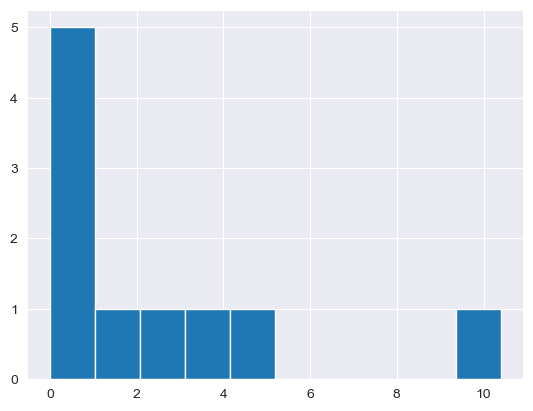

In [554]:
plt.hist(F_list.values())

In [556]:
count = 0
for ticker, F in F_list.items():
    if F > 10:
        count += 1
        print(ticker)
print(count/len(F_list)*100, '%')

GC
10.0 %


In [542]:
print('RMSE mean adj length average for historical mean: ', np.mean(np.sqrt(list(result_meta_fc['vanilla']['MSE_historical_mean_adj_length'].values()))))
print('RMSE mean adj length average for AR1: ', np.mean(np.sqrt(list(result_meta_fc['vanilla']['MSE_adj_length'].values()))))
print('RMSE mean adj length average for AR1 IV v1: ', np.mean(np.sqrt(list(result_meta_fc['iv_pred_v1']['MSE_adj_length'].values()))))
print('RMSE mean adj length average for AR1 IV v2: ', np.mean(np.sqrt(list(result_meta_fc['iv_pred_v2']['MSE_adj_length'].values()))))

RMSE mean adj length average for historical mean:  0.041966232858376945
RMSE mean adj length average for AR1:  0.059091677091238616
RMSE mean adj length average for AR1 IV v1:  0.04289872820324731
RMSE mean adj length average for AR1 IV v2:  0.04217722934002945


In [206]:
result_meta_fc['vanilla']['MSE_historical_mean_adj_length'].keys()

dict_keys(['AD', 'BP', 'CD', 'EU', 'JY', 'SF', 'CL', 'NG', 'GC', 'SI', 'ES'])

In [543]:
print('RMSE mean adj length average for historical mean: ', np.round(np.sqrt(list(result_meta_fc['vanilla']['MSE_historical_mean_adj_length'].values())), 4))
print('RMSE mean adj length average for AR1: ', np.round(np.sqrt(list(result_meta_fc['vanilla']['MSE_adj_length'].values())), 4)) #34
print('RMSE mean adj length average for AR1 IV v1: ', np.round(np.sqrt(list(result_meta_fc['iv_pred_v1']['MSE_adj_length'].values())), 4))
print('RMSE mean adj length average for AR1 IV v2: ', np.round(np.sqrt(list(result_meta_fc['iv_pred_v2']['MSE_adj_length'].values())), 4))

RMSE mean adj length average for historical mean:  [0.0154 0.0121 0.0103 0.0104 0.0111 0.0124 0.2727 0.0404 0.0184 0.0366
 0.0219]
RMSE mean adj length average for AR1:  [0.0154 0.0121 0.0103 0.0103 0.0112 0.0124 0.4606 0.0405 0.0185 0.0367
 0.0219]
RMSE mean adj length average for AR1 IV v1:  [0.0153 0.0121 0.0102 0.0104 0.0111 0.0126 0.2826 0.0404 0.0185 0.0368
 0.0219]
RMSE mean adj length average for AR1 IV v2:  [0.0154 0.0121 0.0103 0.0104 0.0111 0.0125 0.274  0.0404 0.0185 0.0375
 0.0219]


In [208]:
# one-sample dependent one-sided alternative t-test for to find any significant differences between models
for ticker in tickers_fc:
    start_idx = len(result_meta_fc['vanilla']['errors'][ticker]) - len(result_meta_fc['iv_pred_v1']['errors'][ticker])
    assert len(result_meta_fc['vanilla']['errors'][ticker]['Error'].iloc[start_idx:]) == len(result_meta_fc['iv_pred_v1']['errors'][ticker]['Error'])
    test = stats.ttest_rel(np.array(result_meta_fc['iv_pred_v1']['errors'][ticker]['Error'])**2, np.array(result_meta_fc['vanilla']['errors'][ticker]['Error'].iloc[start_idx:])**2, alternative='greater')
    # print(test)
    if test[1] < 0.05:
        print(ticker, '\n', test)
        print('RMSE iv_pred_v1: ', np.sqrt(result_meta_fc['iv_pred_v1']['MSE_adj_length'][ticker]), '\nRMSE vanilla: ', np.sqrt(result_meta_fc['vanilla']['MSE_adj_length'][ticker]), '\nDifference: ', np.sqrt(result_meta_fc['iv_pred_v1']['MSE_adj_length'][ticker]) - np.sqrt(result_meta_fc['vanilla']['MSE_adj_length'][ticker]))
        print('\n--------------------\n')

In [375]:
# significance = 0.05 # loop to find tickers with significant difference
# tickers_with_significant_difference_in_errors_fc_iv_v1 = []
# for ticker in tickers_fc:
#     if ticker == "ES":
#         continue
#     if scipy.stats.ttest_ind(result_meta_fc['vanilla']['errors'][ticker]['Error'].to_list(), result_meta_fc['iv_pred_v1']['errors'][ticker]['Error'].to_list(), equal_var = False)[1] < significance: # False - Welch’s t-test, does not assume equal population variance
#         tickers_with_significant_difference_in_errors_fc_iv_v1.append(ticker)
# print(tickers_with_significant_difference_in_errors_fc_iv_v1)

In [267]:
significance = 0.05 # loop to find tickers with significant difference
tickers_with_significant_difference_in_errors_fc_iv_v2 = []
for ticker in tickers_fc:
    if ticker == "ES":
        continue
    if scipy.stats.ttest_ind(result_meta_fc['vanilla']['errors'][ticker]['Error'].to_list(), result_meta_fc['iv_pred_v2']['errors'][ticker]['Error'].to_list(), equal_var = False)[1] < significance: # False - Welch’s t-test, does not assume equal population variance
        tickers_with_significant_difference_in_errors_fc_iv_v2.append(ticker)
print(tickers_with_significant_difference_in_errors_fc_iv_v2)

[]


In [434]:
print(stats.mannwhitneyu(list(result_meta_fc['vanilla']['MSE'].values()), list(result_meta_fc['iv_pred_v1']['MSE'].values())))
print(stats.mannwhitneyu(list(result_meta_fc['vanilla']['MSE'].values()), list(result_meta_fc['iv_pred_v2']['MSE'].values())))

MannwhitneyuResult(statistic=51.0, pvalue=0.9698499769931556)
MannwhitneyuResult(statistic=51.5, pvalue=0.9397203669477441)


In [435]:
df_mse = pd.DataFrame.from_dict(result_meta_fc['vanilla']['MSE'], orient='index', columns=['MSE_vanilla'])
df_mse = df_mse.join(pd.DataFrame.from_dict(result_meta_fc['vanilla']['MSE_historical_mean'], orient='index', columns=['MSE_historical_mean']))
df_mse = df_mse.join(pd.DataFrame.from_dict(result_meta_fc['iv_pred_v1']['MSE'], orient='index', columns=['MSE_iv_v1']))
df_mse = df_mse.join(pd.DataFrame.from_dict(result_meta_fc['iv_pred_v2']['MSE'], orient='index', columns=['MSE_iv_v2']))
df_mse.head()

,MSE_vanilla,MSE_historical_mean,MSE_iv_v1,MSE_iv_v2
AD,0.000266,0.000265,0.000237,0.000265
BP,0.000147,0.000146,0.000147,0.000147
CD,0.000111,0.000110,0.000105,0.000110
JY,0.000126,0.000124,0.000124,0.000124
SF,0.000155,0.000155,0.000158,0.000156


In [436]:
df_mse['Best Performing model'] = df_mse[['MSE_vanilla', 'MSE_historical_mean', 'MSE_iv_v1', 'MSE_iv_v2']].apply(lambda x: 'AR1' if x[0] < x[1] and x[0] < x[2] and x[0] < x[3] else 'historical mean' if x[1] < x[0] and x[1] < x[2] and x[1] < x[3] else 'IV v1' if x[2] < x[0] and x[2] < x[1] and x[2] < x[3] else 'IV v2', axis=1)

/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_20717/3199995092.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_mse['Best Performing model'] = df_mse[['MSE_vanilla', 'MSE_historical_mean', 'MSE_iv_v1', 'MSE_iv_v2']].apply(lambda x: 'AR1' if x[0] < x[1] and x[0] < x[2] and x[0] < x[3] else 'historical mean' if x[1] < x[0] and x[1] < x[2] and x[1] < x[3] else 'IV v1' if x[2] < x[0] and x[2] < x[1] and x[2] < x[3] else 'IV v2', axis=1)


<Axes: xlabel='Best Performing model', ylabel='Count'>

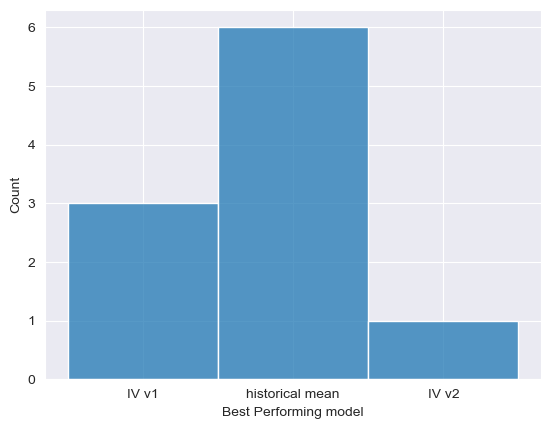

In [437]:
sns.histplot(df_mse['Best Performing model'])

In [276]:
df_mse.mean(axis=0)

/var/folders/tj/3h1b3qks39x9tkrzl6ptzs340000gn/T/ipykernel_96467/1685114325.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_mse.mean(axis=0)


MSE_vanilla            0.020328
MSE_historical_mean    0.007414
MSE_iv_v1              0.008490
MSE_iv_v2              0.007471
dtype: float64

In [63]:
# MSE of historical mean forecast
# for how many stocks outperform
# what fraction of the stocks have MSE lower that the market - ?
# for each stock, what is the best performing model from the 3 models (mean is the last one)? 
# do the analysis for the commodities, bonds, futures, too
# wrap this up for a paper 1-2 pages

# use the same X with IV coefficient
# look at the pattern with more data
# commodities and currencies back adjusted price google (roll)

# I need more data to try to do more analysis - betas (estimate betas), Market Cap
# template of a paper

# why do we predict using betas with the initial Returns
# what are we trying to find?
# shouldn't the IV's performance be worse in general? The method is used in obtaining more consistent and unbiased results
# should I do tests for AR, heteroskedasticity, etc? (Durbin-Watson, Shapiro-Wilk)


# verify with just using SPY instead of 2SLS
# what drives the IV model to underperform? (fitted with the plot MSE)
# plot the average AR and IV coefficients (the last one)
# why MSE for fc seem to be significant, but the MannWhitney test doesn't work
# compute root MSE
# unit root problems?

# R^2?
# autocorrelation of the residuals
# The error measures in the validation period are also very important--indeed, in theory the model's performance in the validation period is the best guide to its ability to predict the future. The caveat here is the validation period is usually a much smaller sample of data than the estimation period. Hence, it is possible that a model may do unusually well or badly in the validation period merely by virtue of getting lucky or unlucky--e.g., by making the right guess about an unforeseeable upturn or downturn in the near future, or by being less sensitive than other models to an unusual event that happens at the start of the validation period. Unless you have enough data to hold out a large and representative sample for validation, it is probably better to interpret the validation period statistics in a more qualitative way: do they wave a "red flag" concerning the possible unreliability of statistics in the estimation period, or not? (Remember that the comparative error statistics that Statgraphics reports for the estimation and validation periods are in original, untransformed units. If you used a log transformation as a model option in order to reduce heteroscedasticity in the residuals, you should expect the unlogged errors in the validation period to be much larger than those in the estimation period. Of course, you can still compare validation-period statistics across models in this case.)



I just wanted to know if you received everything for my application to be completed. Could you approximately tell me how long does the review process take?  

SyntaxError: expected 'else' after 'if' expression (3045677414.py, line 32)